In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
covertype = fetch_ucirepo(id=31)

# data (as pandas dataframes)
X = covertype.data.features
y = covertype.data.targets

# metadata
print(covertype.metadata)

# variable information
print(covertype.variables)


{'uci_id': 31, 'name': 'Covertype', 'repository_url': 'https://archive.ics.uci.edu/dataset/31/covertype', 'data_url': 'https://archive.ics.uci.edu/static/public/31/data.csv', 'abstract': 'Classification of pixels into 7 forest cover types based on attributes such as elevation, aspect, slope, hillshade, soil-type, and more.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 581012, 'num_features': 54, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['Cover_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C50K5N', 'creators': ['Jock Blackard'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting forest cover type from cartographic variables only (no remotely sensed data).  The actual forest cover type for a given observation (30 x 30 meter cell) was determined from

In [ ]:
# Fetch Covertype dataset using ucimlrepo
covertype = fetch_ucirepo(id=31)

# Extract features and target
X = covertype.data.features
y = covertype.data.targets

In [ ]:
# Check for nulls (should be zero)
print(X.isnull().sum().sum(), y.isnull().sum().sum())

# Dataset inspection
print("Features:", X.shape)
print("Target counts:\n", y['Cover_Type'].value_counts())
print("Unique classes:", y['Cover_Type'].nunique())

0 0
Features: (581012, 54)
Target counts:
 Cover_Type
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64
Unique classes: 7


preprocessing


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = X  # skip scaling for tree models
y_encoded = y['Cover_Type'] - 1


train and test

In [ ]:
# Train-test split with corrected labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

model training random and xgboot

random forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


XGBOOT

In [ ]:
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


In [ ]:
print("Random Forest:\n", classification_report(y_test, y_pred_rf))
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))


Random Forest:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95     42368
           1       0.95      0.97      0.96     56661
           2       0.94      0.96      0.95      7151
           3       0.91      0.86      0.88       549
           4       0.95      0.78      0.86      1899
           5       0.93      0.89      0.91      3473
           6       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.92    116203
weighted avg       0.95      0.95      0.95    116203

XGBoost:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85     42368
           1       0.87      0.90      0.88     56661
           2       0.89      0.91      0.90      7151
           3       0.88      0.86      0.87       549
           4       0.89      0.61      0.72      1899
           5       0.85      0.80      0.82      347

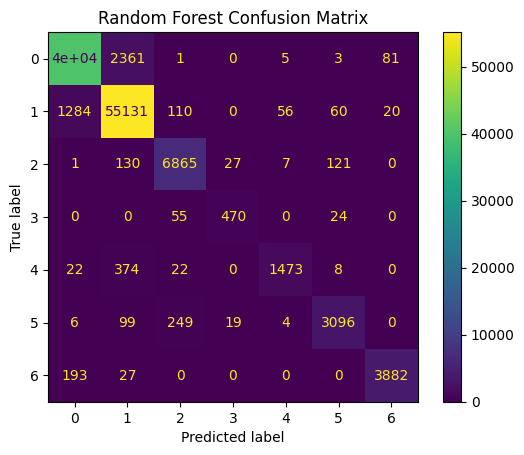

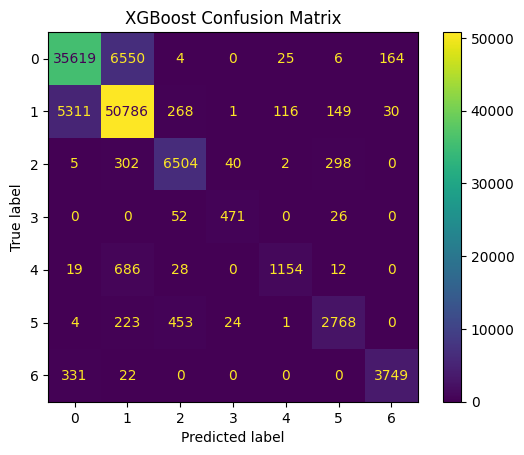

In [ ]:
# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf).plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

# XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(cm_xgb).plot()
plt.title("XGBoost Confusion Matrix")
plt.show()



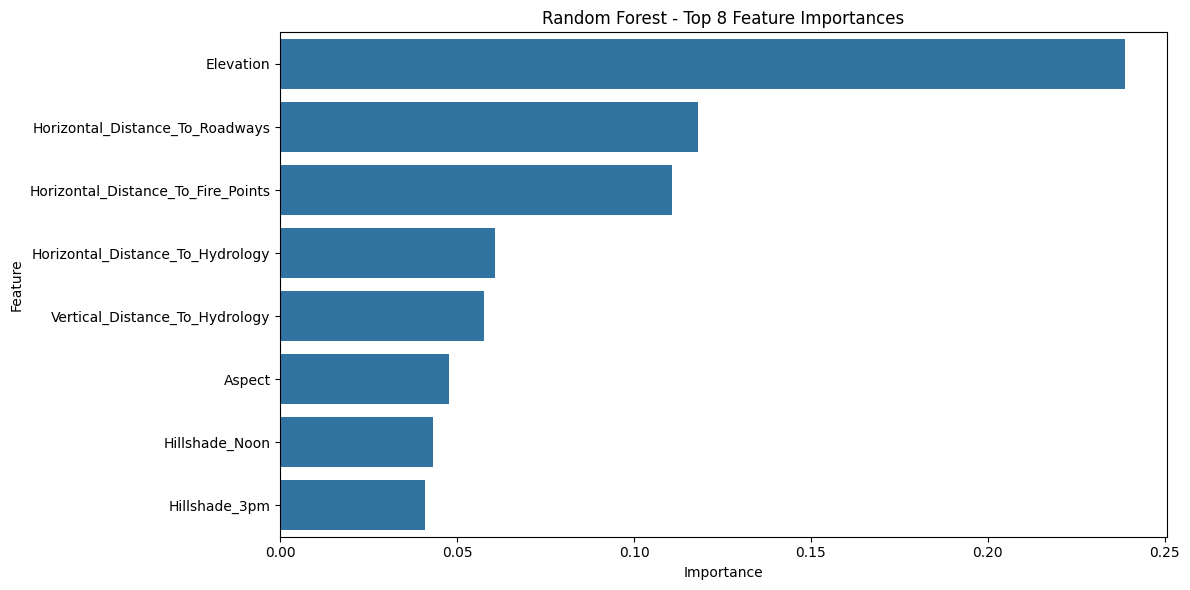

In [ ]:
importances_rf = rf.feature_importances_
features = X.columns

# Create a DataFrame for easy plotting
rf_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances_rf
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df.head(8))  # Top 15
plt.title('Random Forest - Top 8 Feature Importances')
plt.tight_layout()
plt.show()


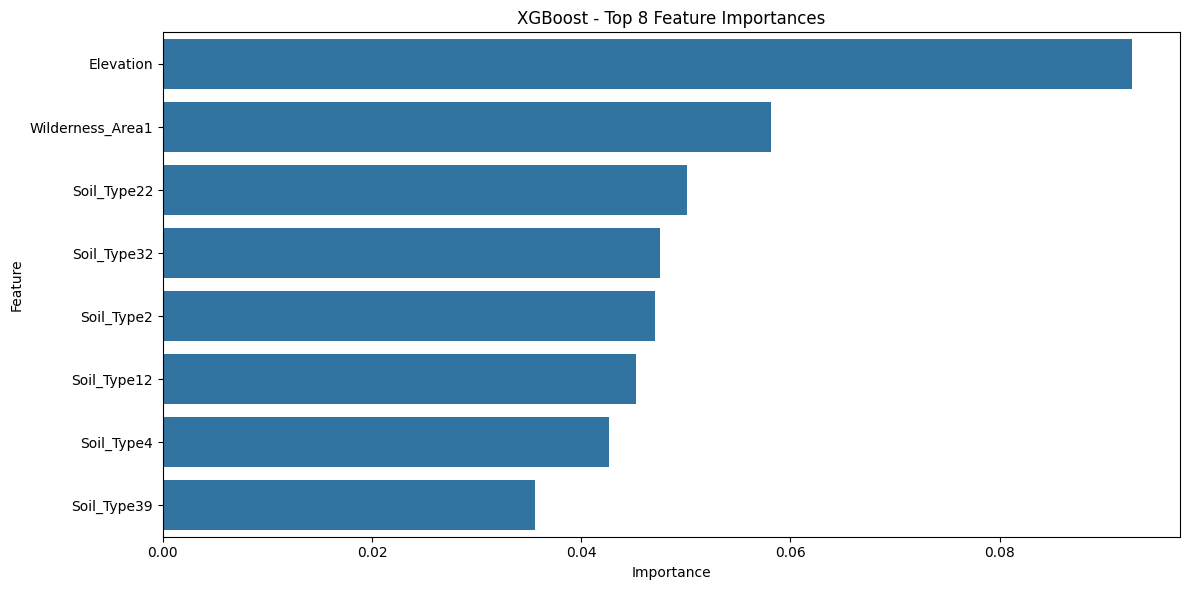

In [ ]:
importances_xgb = xgb.feature_importances_

xgb_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances_xgb
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importance_df.head(8))  # Top 15
plt.title('XGBoost - Top 8 Feature Importances')
plt.tight_layout()
plt.show()


In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all cores
    verbose=1
)

# Fit to training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.8871170744677705


In [ ]:

# Define parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [4, 8],
    'learning_rate': [0.05, 0.1]
}

# Set up the GridSearch
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid_xgb,
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_xgb.fit(X_train, y_train)

# Best parameters and accuracy
print("Best XGBoost Parameters:", grid_xgb.best_params_)
print("Best XGBoost CV Accuracy:", grid_xgb.best_score_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:38:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}
Best XGBoost CV Accuracy: 0.8904388640495032
